# 09.1: A/B Testing

---

## Outline for A/B Tests

* Set up the experiment.
* Run the test and record the success rate for each group.
* Plot the distribution of the difference between the two samples.
* Calculate the statistical power.
* Evaluate how sample size affects A/B tests.

## Problem Statement

We will run an A/B test for a hypothetical company that is trying to increase the amount of users that sign up for a premium account. The goal of running an A/B test is to evaluate if a change in a website will lead to improved performance in a specific metric. You may decide to test very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines. You could also run an A/B test on multi-step processes which may have many differences. Examples of this include the steps required in signing up a new user or processing the sale on an online marketplace

## Baseline Conversion Rate and Lift

Before running the test, we will know the baseline conversion rate and the desired lift or increase in signups that we would like to test. The baseline conversion rate is the current rate at which we sign up new users under the existing design.
    * For our example, we want to use our test to confirm that the changes we make to our signup process will result in atleast a 2% increase in our sign up rate. We currently sign up 10 out of 100 users who are offered a premium account.

In [1]:
import scipy.stats as scs
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# code in Python

# baseline conversion rate
bcr = 0.10 

# difference between the groups
d_hat = 0.02 

## Control Group (A) and Test Group (B)

Typically, the total number of users participating in the A/B test make up a small percentage of the total amount of users. Users are randomly selected and assigned to either a control group or a test group. The sample size that you decide on will determine how long you might have to wait until you have collected enough.
    * For example, websites with large audiences may be able to collect enough data very quickly, while other websites may have to wait a number of weeks. There are some events that happen rarely even for high-traffic websites, so determining the necessary sample size will inform how soon you can assess your experiment and move on to improving other metrics.

In [3]:
# A is control
N_A = 1000

# B is test
N_B = 1000

## Run the Test
Because this is a hypothetical example, we will need “fake” data to work on. So, we will generate some random data for our simulation. 

In [4]:

def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
                
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [5]:
# lets use the above function and generate a sample of data for our ab testing
ab_data = generate_data(N_A, N_B, bcr, d_hat)

# lets check the shape of the data
ab_data.shape

(2000, 2)

In [6]:
# lets check the head of the data
ab_data.head()

,group,converted
0,B,0
1,A,0
2,B,0
3,B,0
4,A,0


In [7]:
# lets also check the distribution of values in both the column

from ipywidgets import interact
from ipywidgets import interact_manual

@interact
def check(column = ab_data.columns):
    return ab_data[column].value_counts()

interactive(children=(Dropdown(description='column', options=('group', 'converted'), value='group'), Output())…

**The converted column indicates whether a user signed up for the premium service or not with a 1 or 0, respectively. The A group will be used for our control group and the B group will be our test group.**

In [8]:
# using pivot table to check how many people got converted to premium membership

ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary

,converted
group,
A,103
B,23


In [9]:
# add additional columns to the pivot table

# adding the total number of people
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))

# adding the rate of conversion
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')
ab_summary['rate'] = ab_summary['rate'].apply(lambda x: x*100)
ab_summary

,converted,total,rate
group,,,
A,103,1014,10.157791
B,23,986,2.332657


* ```It looks like the difference in conversion rates between the two groups is almost 6% which is greater than the lift we initially wanted of 0.02. This is a good sign but this is not enough evidence for us to confidently go with the new design. At this point we have not measured how confident we are in this result. This can be mitigated by looking at the distributions of the two groups.```


## Compare the Two Groups

We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).

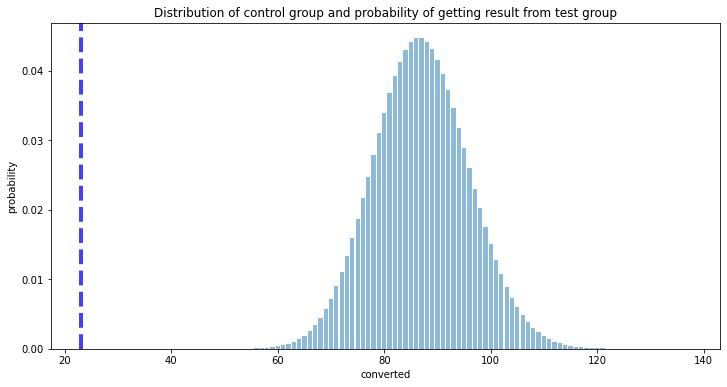

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')

A_converted = 87
A_total = 1023
A_cr = 0.085
B_cr = 0.0225

x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='blue', alpha=0.75, linestyle='--')

plt.title('Distribution of control group and probability of getting result from test group', fontsize = 12)
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()

* The distribution for the control group is shown in blue and the result from the test group is indicated by the blue dashed line.

* We can see that the probability of getting the result from the test group was very low. 

* However, the probability does not convey the confidence level of the results.

* It does not take the sample size of our test group into consideration. 

Intuitively, we would feel more confident in our results as our sample sizes grow larger. Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

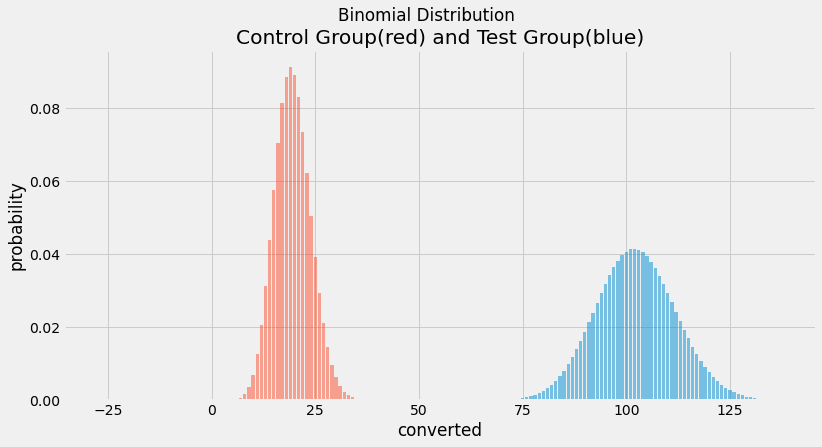

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

p_A = 0.1 # same as bcr
p_B = 0.02 # same as d_hat
B_converted = 22
B_total = 977

xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')
plt.suptitle('Binomial Distribution')
plt.title('Control Group(red) and Test Group(blue)')
plt.show()

* We can see that the control group converted more users than the test group.
* We can also see that the peak of the control group results is lower than the control group. 

**How do we interpret the difference in peak probability?**

    * We should focus instead on the conversion rate so that we have an apples-to-apples comparison. In order to calculate this, we need to standardize the data and compare the probability of successes, p, for each group.

Text(0, 0.5, 'PDF')

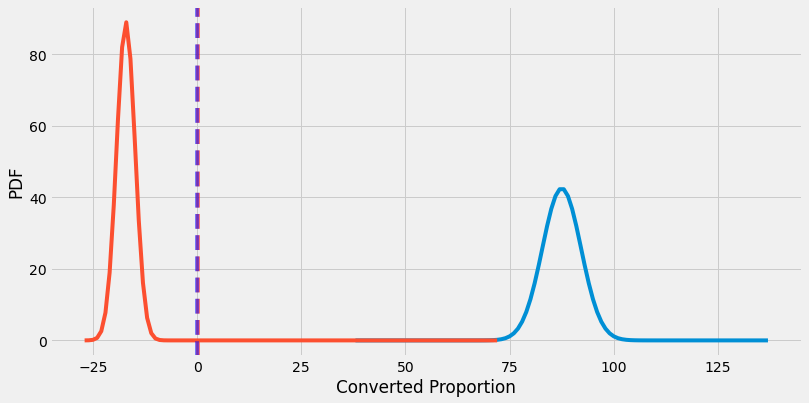

In [12]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0, .2, 100)
yA = scs.norm(p_A, SE_A).pdf(x)

ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

In [13]:
from scipy import stats as scs
from scipy.stats import sem

def abplot(N_a, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = sem(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

In [ ]:
n = N_A + N_B
bcr = p_A  
d_hat = p_B - p_A
abplot(n, bcr, d_hat)